some quick tests with Viero+2022 results from SIMSTACK3

In [23]:
import pickle
import os, sys
from astropy import units as u, constants as c
import numpy as np
from matplotlib import pyplot as plt

In [24]:
with open("simstack.pkl", "rb") as f:
    results = pickle.load(f)
results.keys(), results['wvs'], len(results['seds']), list(results['seds'].keys())[0]

(dict_keys(['wvs', 'seds', 'stds', 'ngals', 'z_med', 'boot', 'cov', 'm_med', 'nd', 'beams']),
 [24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 96,
 'z=0.01_0.5__logM=9.5_10.0__SF?=0')

In [25]:
np.sum(list(results['ngals'].values()))

128873

In [26]:
np.sum(list(results['ngals'].values())[::2]), np.sum(list(results['ngals'].values())[1::2])

(17596, 111277)

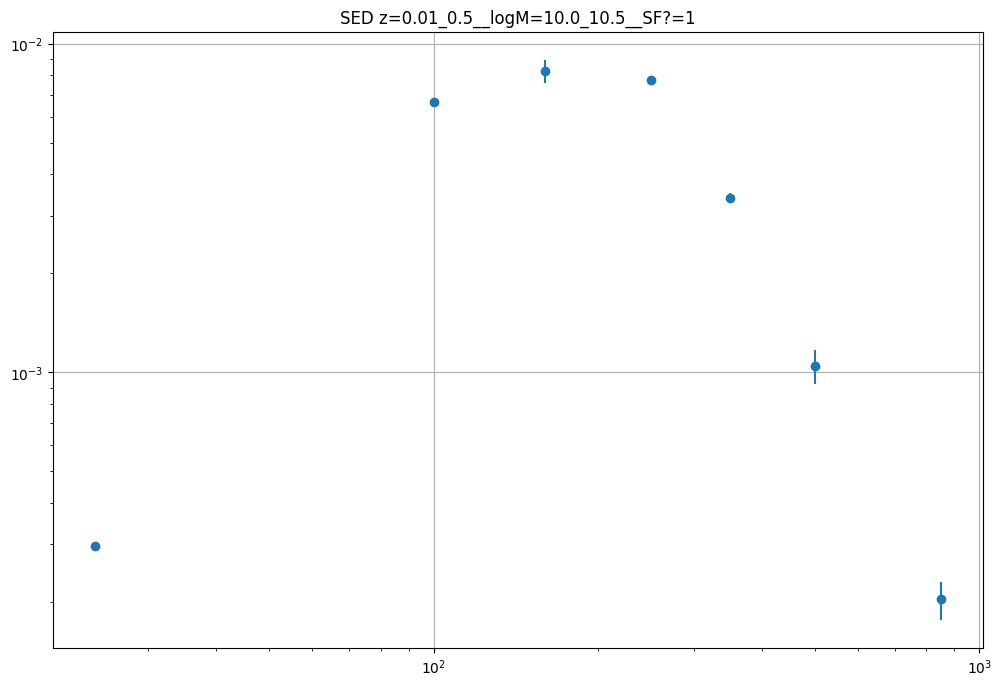

In [27]:
ind = 3
key_to_plot = list(results['seds'].keys())[ind]
plt.figure(figsize=(12, 8))
plt.errorbar(results['wvs'], results['seds'][key_to_plot], yerr=results['stds'][key_to_plot], fmt='o', label=key_to_plot)
plt.title(f"SED {key_to_plot}")
plt.grid()
plt.loglog()
plt.show()
plt.close()

units are in Jy/beam, comparable plots to Figure 1 from Viero+22 paper

Compare to COBE FIRAS FIRB measurements

In [28]:
firas = np.loadtxt('../data/FIRAS_CIB_spectrum.dat', comments='#')
firas.shape

(200, 4)

In [29]:
# first column is freq in cm^-1, rest columns are intensity in MJy/sr
wavs = (1e4 / firas[:,0]) * u.micron
int1 = firas[:,1] * u.MJy / u.sr
int2 = firas[:,2] * u.MJy / u.sr
int3 = firas[:,3] * u.MJy / u.sr

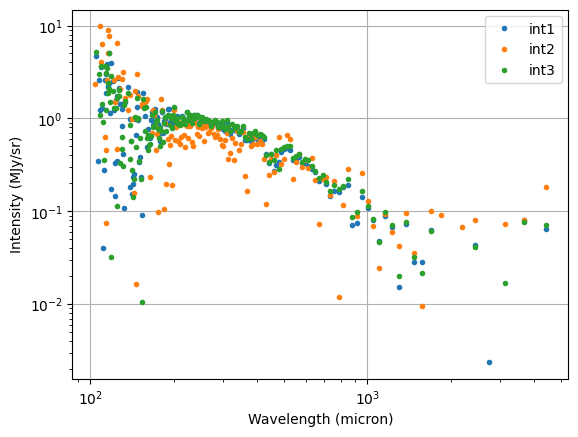

In [30]:
plt.figure()
plt.plot(wavs, int1, label='int1', marker='.', ls='none')
plt.plot(wavs, int2, label='int2', marker='.', ls='none')
plt.plot(wavs, int3, label='int3', marker='.', ls='none')
plt.xlabel('Wavelength (micron)')
plt.ylabel('Intensity (MJy/sr)')
plt.loglog()
plt.legend()
plt.grid()
plt.show()
plt.close()

In [61]:
beam_sizes = np.array([1.55, 2.03, 4.66, 9.94, 17.65, 37.30, 5.68]) * 1e-9
# values from the Viero+22 paper 2203.14312, Viero+13 paper 1304.0446, and 
# SCUBA beam from https://academic.oup.com/mnras/article/465/2/1789/2454739

total_survey_area = (1.6055 * u.deg**2).to(u.sr).value / (4. * np.pi)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59122/2564070771.py:31: RuntimeWarning: Mean of empty slice
  int1_avg[i] = np.nanmean(int1[mask].value) * 1e6
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59122/2564070771.py:32: RuntimeWarning: Mean of empty slice
  int2_avg[i] = np.nanmean(int2[mask].value) * 1e6
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_59122/2564070771.py:33: RuntimeWarning: Mean of empty slice
  int3_avg[i] = np.nanmean(int3[mask].value) * 1e6


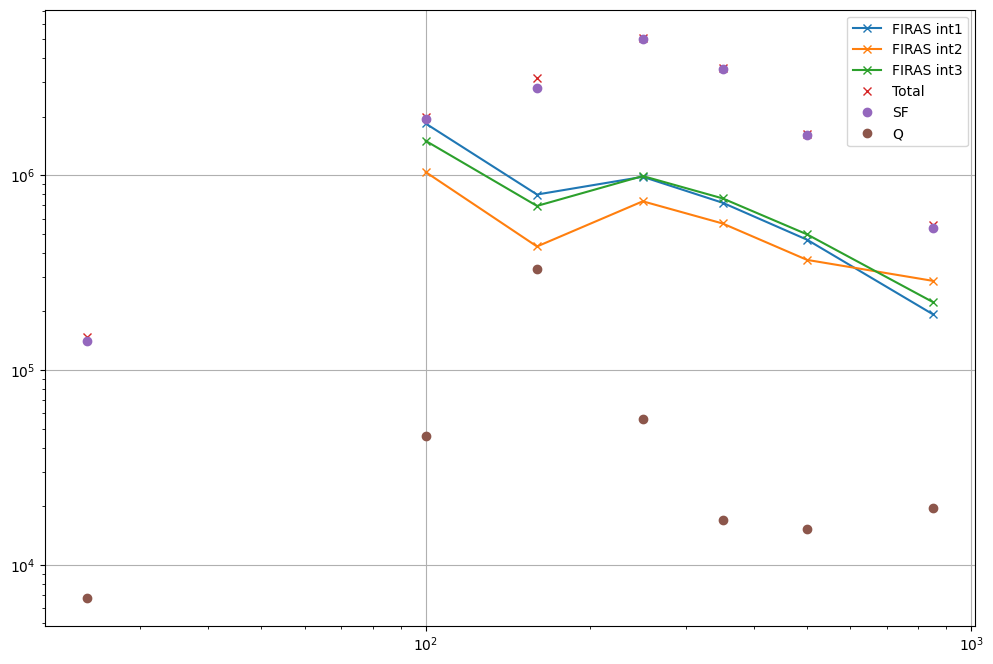

In [64]:
total_star_forming = np.zeros(len(results['wvs']))
total_quiescent = np.zeros(len(results['wvs']))
total = np.zeros(len(results['wvs']))
# total_z1, total_z2, total_z3 = np.zeros(len(results['wvs'])), np.zeros(len(results['wvs'])), np.zeros(len(results['wvs']))

plt.figure(figsize=(12, 8))
for ind in range(len(results['seds'])):
    key_to_plot = list(results['seds'].keys())[ind]
    # if results['stds'][key_to_plot] is None:
    #     continue
    val = results['seds'][key_to_plot] * results['ngals'][key_to_plot] / total_survey_area
    if "SF?=0" in key_to_plot:
        total_quiescent += val
    else:
        total_star_forming += val
    val[val < 0] = 0
    total += val
    # total_int += results['seds'][key_to_plot] * results['ngals'][key_to_plot] / total_survey_area
    # plt.errorbar(results['wvs'], results['seds'][key_to_plot] / beam_sizes, \
    #     yerr=results['stds'][key_to_plot] / beam_sizes, fmt='x', label=key_to_plot)
# plt.plot(wavs, int1 * 1e6, label='FIRAS int1', marker='.', ls='none')
# plt.plot(wavs, int2 * 1e6, label='FIRAS int2', marker='.', ls='none')
# plt.plot(wavs, int3 * 1e6, label='FIRAS int3', marker='.', ls='none')
# plot the FIRAS data, but averaged in small bins
wvs = results['wvs']
int1_avg = np.zeros(len(wvs))
int2_avg = np.zeros(len(wvs))
int3_avg = np.zeros(len(wvs))
for i in range(len(wvs)):
    mask = (wavs.value > wvs[i] - 10) & (wavs.value < wvs[i] + 10)
    int1_avg[i] = np.nanmean(int1[mask].value) * 1e6
    int2_avg[i] = np.nanmean(int2[mask].value) * 1e6
    int3_avg[i] = np.nanmean(int3[mask].value) * 1e6
plt.plot(wvs, int1_avg, label='FIRAS int1', marker='x')
plt.plot(wvs, int2_avg, label='FIRAS int2', marker='x')
plt.plot(wvs, int3_avg, label='FIRAS int3', marker='x')
plt.plot(wvs, total, label='Total', marker='x', ls='none')
plt.plot(wvs, total_star_forming, label='SF', marker='o', ls='none')
plt.plot(wvs, total_quiescent, label='Q', marker='o', ls='none')
plt.legend()
plt.grid()
plt.loglog()
plt.show()  
plt.close()

24.0 nan -0.8478123018389346
100.0 1.3178867164978094 -0.36588459099556114
160.0 4.519152944601329 0.014584654407102216
250.0 5.181214570992987 0.5852885225110971
350.0 4.902292613847931 1.219403931515536
500.0 3.4704852596471407 2.170577045022194
850.0 2.4822057832919038 4.38998097653773


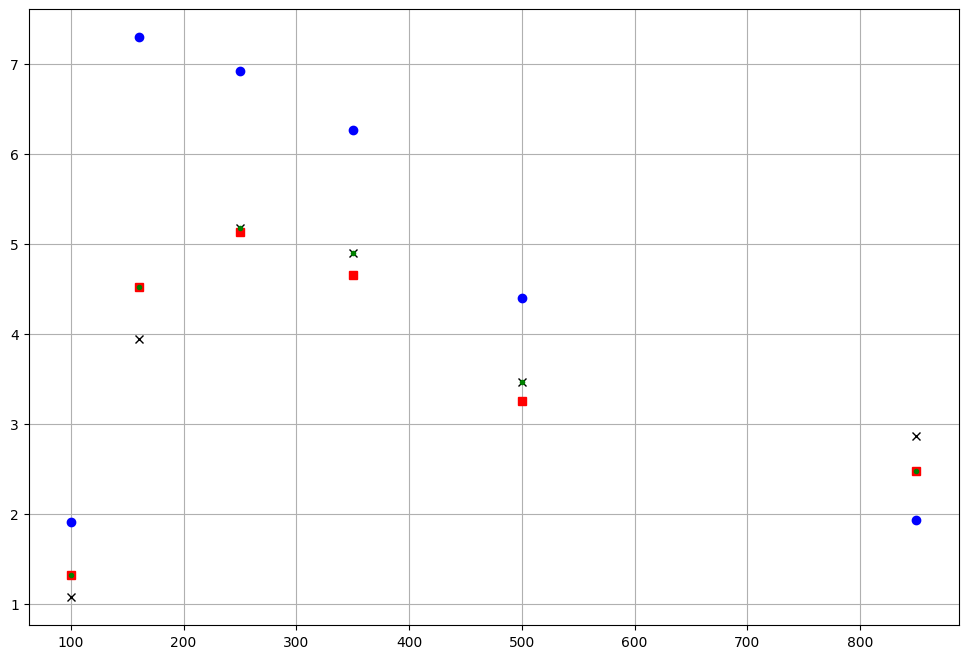

In [65]:
# plot fraction
plt.figure(figsize=(12, 8))
for ind, wv in enumerate(results['wvs']):
    val1 = total[ind] / int1_avg[ind]
    val2 = total[ind] / int2_avg[ind]
    val3 = total[ind] / int3_avg[ind]
    # print(wv, val1, val2, val3)
    mval = np.median([val1, val2, val3])
    plt.plot(wv, val1, marker='x', ls='none', color='k')
    plt.plot(wv, val2, marker='o', ls='none', color='b')
    plt.plot(wv, val3, marker='s', ls='none', color='r')
    plt.plot(wv, mval, marker='.', ls='none', color='g')
    print(wv, mval, wv/157.7-1)
plt.grid()
plt.show()
plt.close()

24.0 0.009088101285447703 -0.8478123018389346
100.0 0.12611172447828353 -0.36588459099556114
160.0 0.5761579560837766 0.014584654407102216
250.0 0.43294896286011225 0.5852885225110971
350.0 0.44475902329510525 1.219403931515536
500.0 0.45426350786517855 2.170577045022194
850.0 0.3119133889357144 4.38998097653773


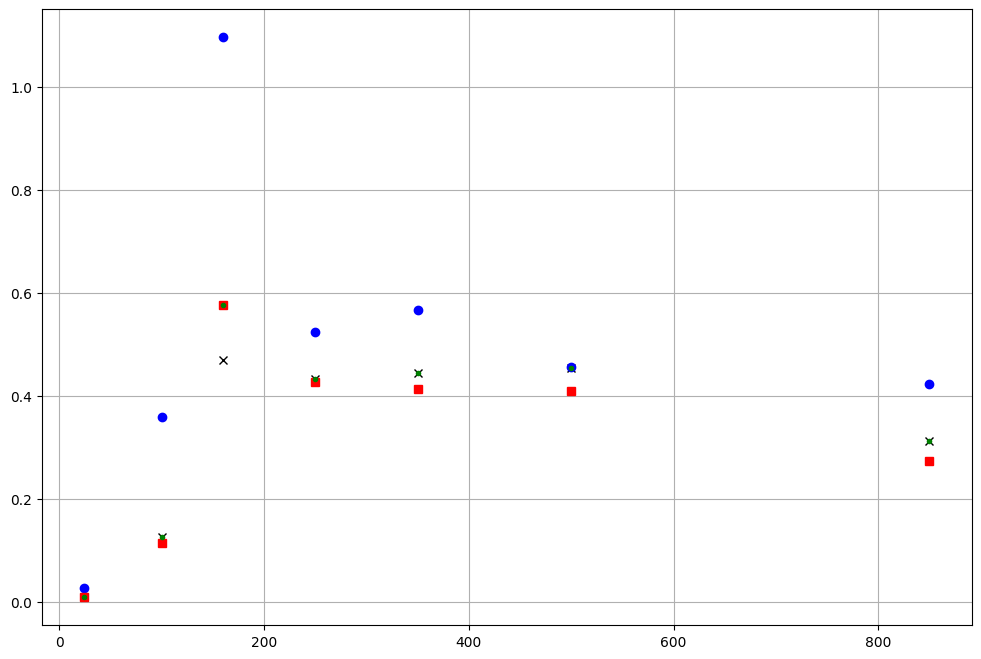

In [41]:
# plot fraction
plt.figure(figsize=(12, 8))
for ind, wv in enumerate(results['wvs']):
    wav_ind = np.argmin(np.abs(wavs.value - wv))
    mg = 10
    val1 = total[ind] / np.nanmedian(int1[wav_ind-mg: wav_ind+mg]) / 1e6
    val2 = total[ind] / np.nanmedian(int2[wav_ind-mg: wav_ind+mg]) / 1e6
    val3 = total[ind] / np.nanmedian(int3[wav_ind-mg: wav_ind+mg]) / 1e6
    # print(wv, val1, val2, val3)
    mval = np.median([val1.value, val2.value, val3.value])
    plt.plot(wv, val1, marker='x', ls='none', color='k')
    plt.plot(wv, val2, marker='o', ls='none', color='b')
    plt.plot(wv, val3, marker='s', ls='none', color='r')
    plt.plot(wv, mval, marker='.', ls='none', color='g')
    print(wv, mval, wv/157.7-1)
plt.grid()
plt.show()
plt.close()